# Tomato Disease Classification

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-10-07 08:54:15.104845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 08:54:15.230512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 08:54:15.313299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 08:54:16.012396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Collection and Preprocessing

First lets load all the image files from our directory to a tensorflow dataset. (all the images are 256x256)

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 # RGB Channels

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage_dataset/",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [11]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [12]:
len(dataset)

501

In [13]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 5 7 0 0 5 0 5 6 9 1 8 0 6 5 0 0 0 7 5 7 6 9 5 0 7 2 4 2 7 2 7]


Lets try to visualize the images

2024-10-07 08:56:21.349128: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


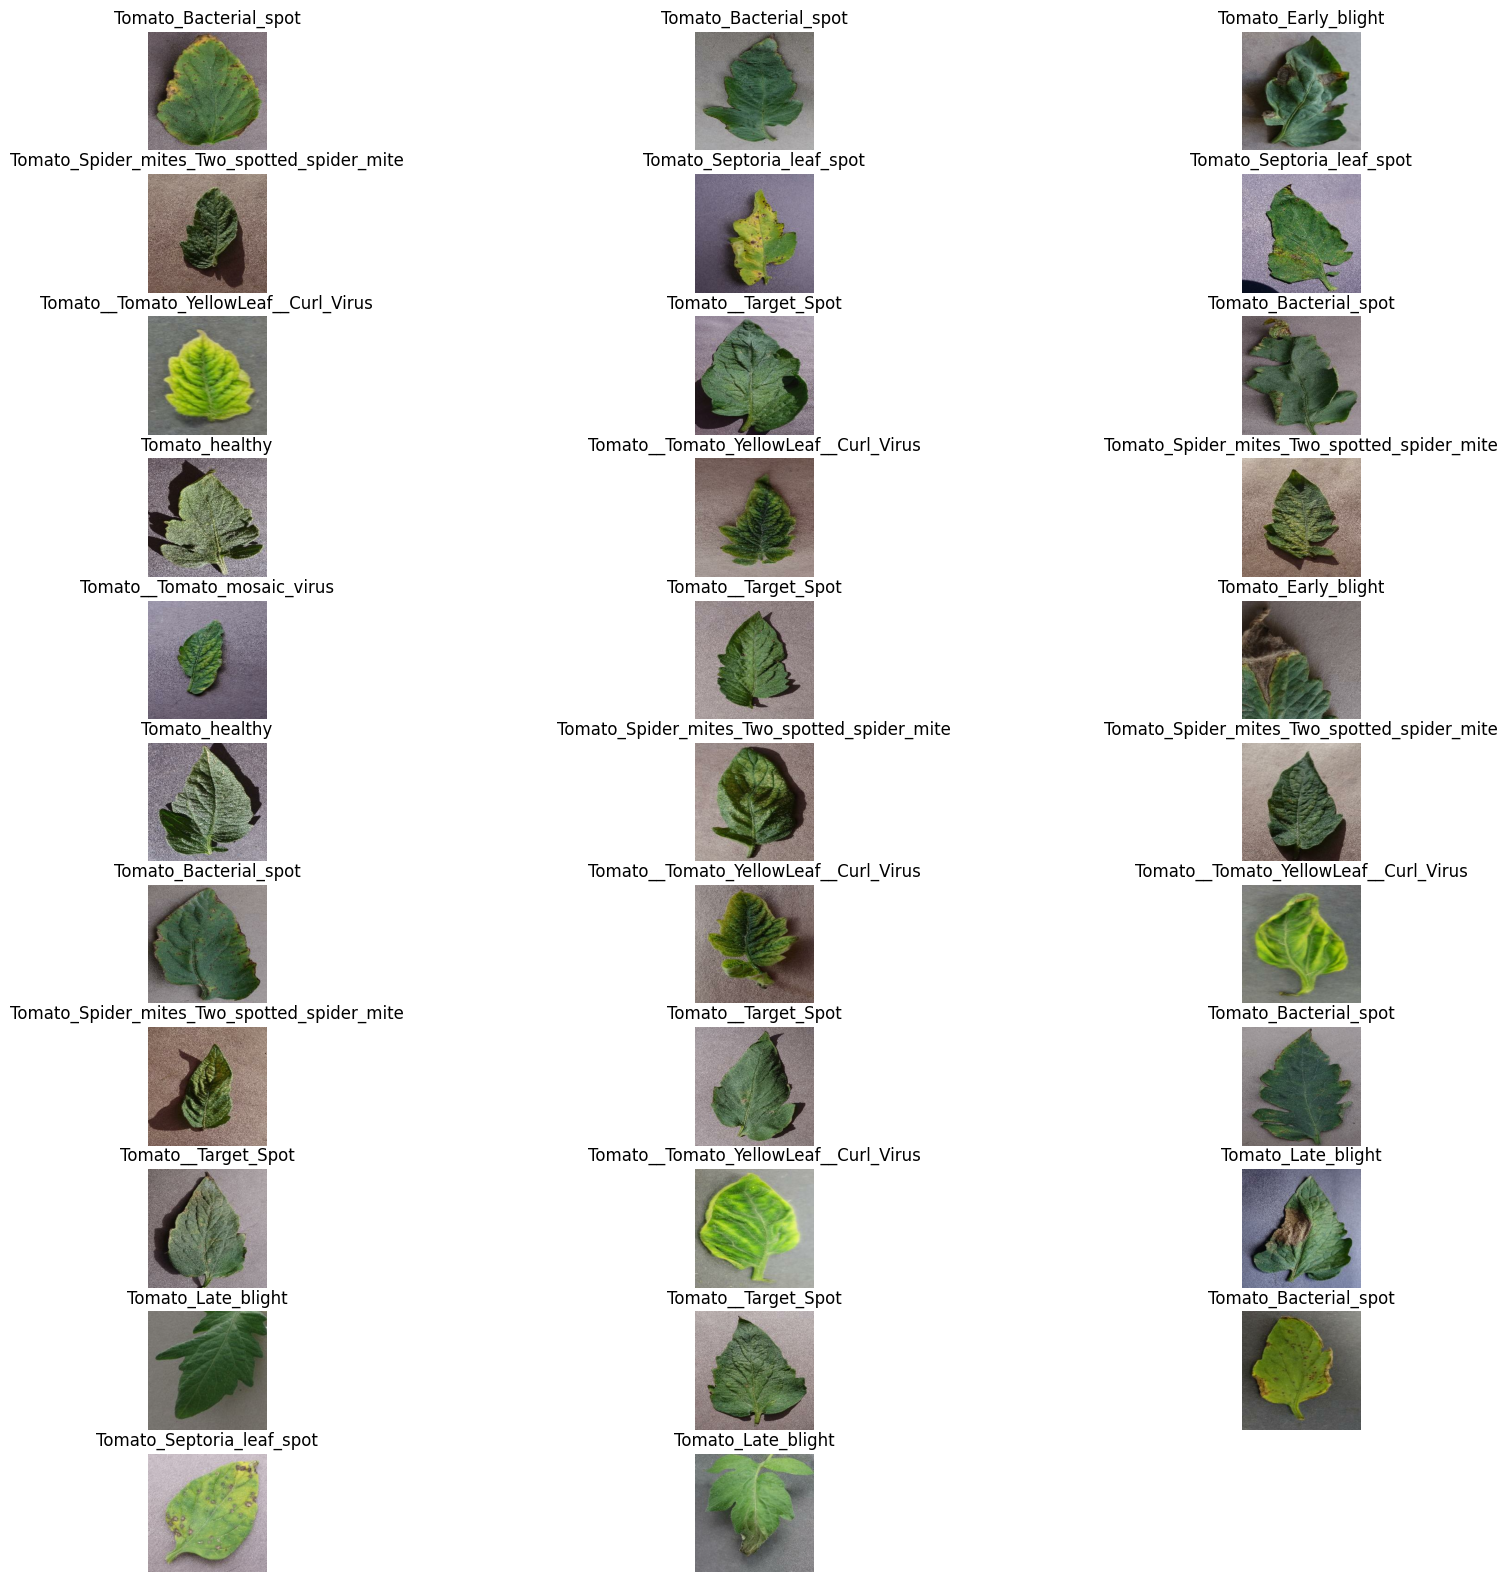

In [14]:
plt.figure(figsize = (20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(11,3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        index = labels_batch[i]
        plt.title(class_names[index])
        plt.axis('OFF')

### Lets perform test-train-split

80% ==> Training \
20% ==> 10% Validation, 10% Test

In [15]:
train_size = 0.8
len(dataset)*train_size

400.8

So we need 400 batches in training set and rest for testing and validation

In [16]:
train_ds = dataset.take(400)
len(train_ds)

400

In [17]:
temp_ds = dataset.skip(400)
len(temp_ds)

101

In [18]:
val_size = 0.1
len(dataset)*val_size

50.1

In [19]:
val_ds = temp_ds.take(50)
len(val_ds)

50

In [20]:
test_ds = temp_ds.skip(50)
len(test_ds)

51

Now lets make a function to do the above steps of train-test-split

In [21]:
def get_tf_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_tf_dataset_partitions(dataset)

In [23]:
print(len(train_ds), len(val_ds), len(test_ds))

400 50 51


### Cache, Shuffle, and Prefetch the Dataset

In [24]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Scaling

In [25]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

We are reshaping each image even though all training sample are 256, 256 so that when we give an img to predict which is not of this size, it will work.\
We divide by 255 for scaling as RGB values range from 0 to 255

We will supply these layers to our model.

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(0.2, 0.6)),
    layers.RandomContrast(0.3)
])

## Model

In [27]:
import os
os.environ['TF_CPP_LOG_LEVEL'] = "2"

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(25, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(30, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    ##layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 25)     │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 30)     │         6,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 32)       │         8,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 28800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 10)               │       288,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,162 (1.16 MB)

 Trainable params: 304,162 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [31]:
model.fit(
    train_ds,
    epochs = 5,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5


2024-10-07 08:57:44.095953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 29 of 1000
2024-10-07 08:57:57.258766: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 1073741824 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-10-07 08:57:57.258828: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 1073741824
2024-10-07 08:57:57.417946: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 966367744 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-10-07 08:57:57.418001: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 966367744
2024-10-07 08:57:57.600605: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 869731072 bytes on host: CUDA_ER

ResourceExhaustedError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_17473/2456337003.py", line 1, in <module>

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 120, in one_step_on_iterator

Detected at node IteratorGetNext defined at (most recent call last):
  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_17473/2456337003.py", line 1, in <module>

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/niel/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 120, in one_step_on_iterator

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_2771]

2024-10-07 08:59:07.965975: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 154168320 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-10-07 08:59:07.966034: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 154168320
2024-10-07 08:59:07.989650: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 138751488 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-10-07 08:59:07.989781: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned host memory of size: 138751488
2024-10-07 08:59:08.015119: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1641] failed to alloc 124876544 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-10-07 08:59:08.015178: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:61] could not allocate pinned ho